Let's load all the data we plan to use for this model and set the times as the index

In [1]:
import pandas as pd


In [2]:
cdc = pd.read_csv("cdc_average_bystate_2013-2017.csv")
gtrends_shot = pd.read_csv("gtrends_flu_shot.csv")
twitter = pd.read_csv("tweets_with_location.csv") #thanks to Wik for generating this one
gtrends_news = pd.read_csv("flu_news.csv")

In [3]:
cdc.set_index('time', inplace=True)
gtrends_shot.set_index('date', inplace=True)
twitter.set_index('date', inplace=True)
gtrends_news.set_index('date', inplace=True)

In [4]:
cdc.index = pd.to_datetime(cdc.index)
gtrends_shot.index = pd.to_datetime(gtrends_shot.index)
gtrends_news.index = pd.to_datetime(gtrends_news.index)
twitter.index = pd.to_datetime(twitter.index)

cdc.sort_index(inplace=True)
gtrends_shot.sort_index(inplace=True)
gtrends_news.sort_index(inplace=True)
twitter.sort_index(inplace=True)

Since our data goes back 4 years, we will start with the 2014 data

In [5]:
cdc = cdc[cdc.index > pd.Timestamp('2014-01-01')]



The function below helps us calculate monthly vaccination rates from the CDC ground truth:

In [6]:
#will calculate the increment of cdc data which starts in july and then adds up every month
def cdc_increment(timeCol, pctCol):
    diffCol = []
    for i in range(len(timeCol)):
        if timeCol[i].month != 7:
            diffCol.append(pctCol[i]-pctCol[i-1])
        else:
            diffCol.append(pctCol[i])
            
    return diffCol
            
    

In [7]:
#will reverse the process that we used for the cdc data 
def cdc_deincrement(timeCol, pctCol):
    addCol = [pctCol[0].tolist()]
    for i in range(1,len(timeCol)):
        if timeCol[i].month != 7:
            addCol.append(pctCol[i].tolist()+addCol[i-1])
        else:
            addCol.append(pctCol[i].tolist())
            
    return addCol


Function that combines CDC ground truth with most recent gtrends for any given state:

In [8]:
#function that grabs last 2 gtrends points for every CDC date
def combine_cdc_gtrends(gtrends_shot_df, gtrends_news_df, cdc_df):
    cdc_index = cdc_df.index
    cdc_values = cdc_df.mean_pct.values
    gtrends_shot_index = gtrends_shot_df.index
    gtrends_news_index = gtrends_news_df.index
    row_dict = {}
    
    for cdc_date, cdc_value in zip(cdc_index, cdc_values):
        ind = gtrends_shot_index.searchsorted(cdc_date)
        if (gtrends_shot_index[ind] > cdc_date):
            ind = ind - 1
        last_two_gtrends = gtrends_shot_df.iloc[ind-1:ind+1,0].values
        row_dict[cdc_date] = [cdc_value] + last_two_gtrends.tolist()

    for cdc_date, cdc_value in zip(cdc_index, cdc_values):
        ind = gtrends_news_index.searchsorted(cdc_date)
        if (gtrends_news_index[ind] > cdc_date):
            ind = ind - 1
        last_two_gtrends = gtrends_news_df.iloc[ind-1:ind+1,0].values
        row_dict[cdc_date] = row_dict[cdc_date] + last_two_gtrends.tolist()
    
    combined_df = pd.DataFrame.from_dict(row_dict, orient='index')
    combined_df.columns = ['cdc', 'flu-shot-0', 'flu-shot-1', 'flu-news-0', 'flu-news-1']
    return combined_df

Function to put it all together and grab the needed target for a given state:

In [9]:
def get_state_target_df(cdc_df, gtrends_shot_df, gtrends_news_df, state_abbr, state_name):
    cdc_state = cdc_df[cdc_df.state == state_name]
    gtrends_shot_state = gtrends_shot_df[[state_abbr]]
    gtrends_news_state = gtrends_news_df[[state_abbr]]

    state_df = combine_cdc_gtrends(gtrends_shot_state, gtrends_news, cdc_state)
    
    return state_df

Now let's check that things make sense for WA state:

In [10]:
wa_df = get_state_target_df(cdc, gtrends_shot, gtrends_news, 'WA', 'Washington')

In [11]:
wa_df.head(20)

,cdc,flu-shot-0,flu-shot-1,flu-news-0,flu-news-1
2014-01-15,45.0,92,46,15,28
2014-02-15,47.5,8,9,0,0
2014-03-15,47.9,5,3,0,0
2014-04-15,48.3,2,1,0,0
2014-05-15,48.4,2,1,0,0
2014-07-15,0.6,0,3,0,18
2014-08-15,1.8,1,3,0,0
2014-09-15,9.1,16,24,0,17
2014-10-15,28.3,59,77,18,0
2014-11-15,39.4,40,28,0,0


In [12]:
wa_df["cdc_monthly"] = cdc_increment(wa_df.index, wa_df.cdc)

The correlation matrix is reasonable:

In [13]:
wa_df.corr()

,cdc,flu-shot-0,flu-shot-1,flu-news-0,flu-news-1,cdc_monthly
cdc,1.000000,0.082719,-0.026293,0.232045,0.123757,-0.171670
flu-shot-0,0.082719,1.000000,0.905815,0.338064,0.261097,0.608728
flu-shot-1,-0.026293,0.905815,1.000000,0.338530,0.273369,0.797984
flu-news-0,0.232045,0.338064,0.338530,1.000000,0.489854,0.096635
flu-news-1,0.123757,0.261097,0.273369,0.489854,1.000000,-0.142233
cdc_monthly,-0.171670,0.608728,0.797984,0.096635,-0.142233,1.000000


Now we can train a model on all states:

In [14]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}
    

We will build a model for every state individiually, by training on the last 2 years of data, and testing on the first two. (The reason for this is the strange gtrends behavior in early 2018 - as will be discussed in our report):

In [15]:
from sklearn import linear_model
reg = linear_model.LinearRegression()


def train_linear_model(state_df):
    train_df = state_df[(state_df.index > pd.Timestamp('2016-07-01')) & (state_df.index < pd.Timestamp('2018-05-20'))]
    
    X = train_df.reset_index()[['flu-shot-0', 'flu-shot-1', 'flu-news-0', 'flu-news-1']]
    Y = train_df.reset_index()[['cdc_monthly']]
    
    reg.fit(X,Y)
    print(reg.score(X,Y))
    
    return reg

A function that will test the fit for a given state, for 5 different R2 metrics:

-Plain R2 for all test years.

-R2 for 2014.

-R2 for 2015.

-R2 for 2014, using a cumulative form that is similar to the ground truth.

-R2 for 2015, using a cumulative form that is similar to the ground truth.

In [16]:
from sklearn.metrics import r2_score

def test_linear_model(state_df, reg):
    train_df = state_df[(state_df.index > pd.Timestamp('2016-07-01')) & (state_df.index < pd.Timestamp('2018-05-20'))]
    test_df = state_df[state_df.index < pd.Timestamp('2016-05-20')]
    
    X_test = test_df.reset_index()[['flu-shot-0', 'flu-shot-1', 'flu-news-0', 'flu-news-1']]
    Y_test = test_df.reset_index()[['cdc_monthly']]
    
    Y_hat = reg.predict(X_test)

    X_train = train_df.reset_index()[['flu-shot-0', 'flu-shot-1', 'flu-news-0', 'flu-news-1']]
    Y_train = train_df.reset_index()[['cdc_monthly']]
    
    X_combined = state_df.reset_index()[['flu-shot-0', 'flu-shot-1', 'flu-news-0', 'flu-news-1']]

    #we should now score both test years separately
    df_2014 = state_df[(state_df.index > pd.Timestamp('2014-07-01')) & (state_df.index < pd.Timestamp('2015-05-20'))]
    df_2015 = state_df[(state_df.index > pd.Timestamp('2015-07-01')) & (state_df.index < pd.Timestamp('2016-05-20'))]

    X_2014 = df_2014.reset_index()[['flu-shot-0', 'flu-shot-1', 'flu-news-0', 'flu-news-1']]
    Y_2014 = df_2014.reset_index()[['cdc_monthly']]
    
    X_2015 = df_2015.reset_index()[['flu-shot-0', 'flu-shot-1', 'flu-news-0', 'flu-news-1']]
    Y_2015 = df_2015.reset_index()[['cdc_monthly']]
    
    Y_2014_pred = cdc_deincrement(df_2014.index, reg.predict(X_2014).T[0])
    Y_2015_pred = cdc_deincrement(df_2015.index, reg.predict(X_2015).T[0])  
    
    print(reg.score(X_test, Y_test))
    
    return [reg.score(X_test, Y_test), reg.score(X_2014, Y_2014), reg.score(X_2015, Y_2015),
           r2_score(df_2014.cdc.values, Y_2014_pred), r2_score(df_2015.cdc.values, Y_2015_pred)], reg.predict(X_combined)
    

We will now run the test on all states that have shown not to have too much missing data:

Populating the interactive namespace from numpy and matplotlib
Alabama:
R2 train:
0.9297998161872024
The best fit coefficients: [[ 0.19352513  0.05987046 -0.02412571 -0.13736955]]
R2 test:
0.8686697750449845


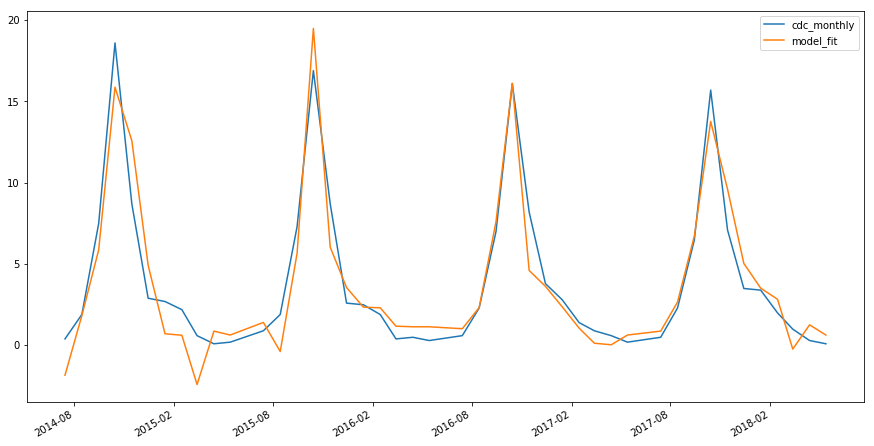


 

Arkansas:
R2 train:
0.8460528941700478
The best fit coefficients: [[ 0.06435658  0.35873163 -0.10951578 -0.04241015]]
R2 test:
0.9159627667150794


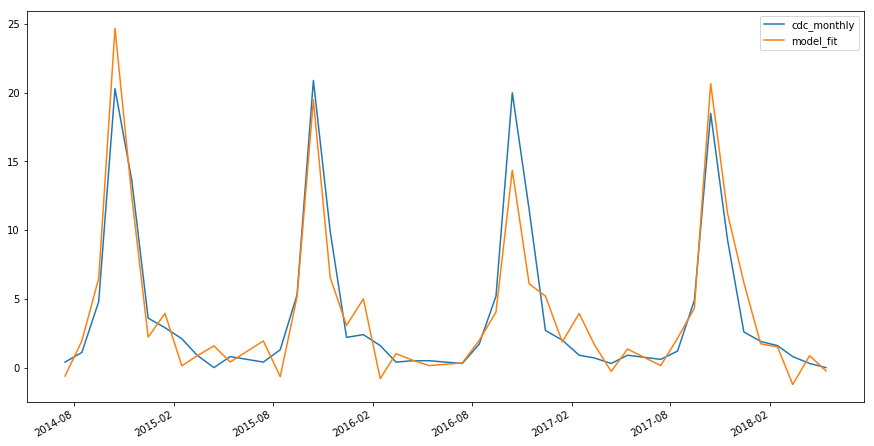


 

Arizona:
R2 train:
0.8601822767845739
The best fit coefficients: [[ 0.0830393   0.14992616 -0.00784165 -0.0911558 ]]
R2 test:
0.9467220224746699


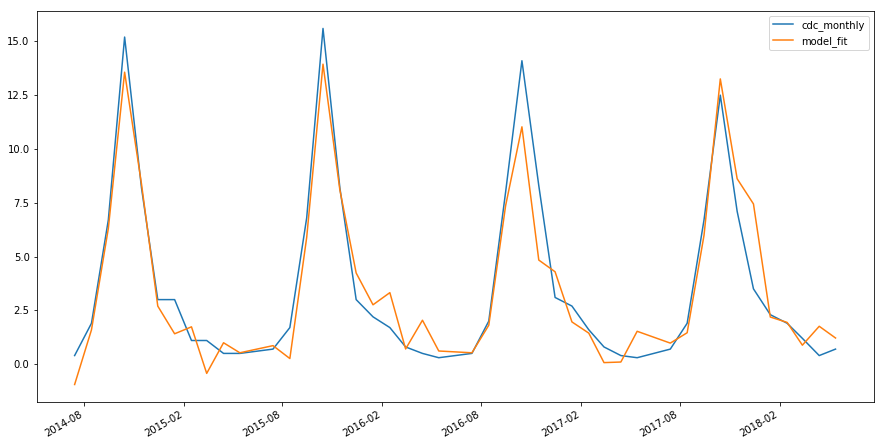


 

California:
R2 train:
0.9094580786709074
The best fit coefficients: [[-0.00955461  0.22391664  0.00768417 -0.13341313]]
R2 test:
0.881210636358991


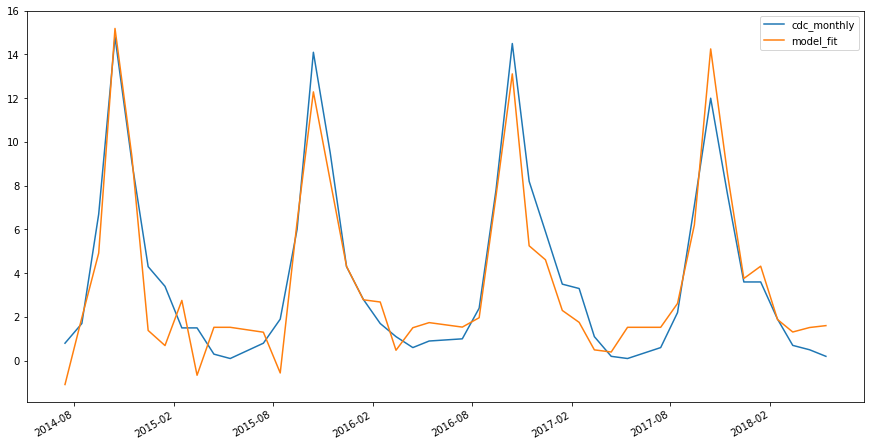


 

Colorado:
R2 train:
0.9523788797975996
The best fit coefficients: [[ 0.01373384  0.31449858 -0.04146393 -0.06679419]]
R2 test:
0.9660345254446137


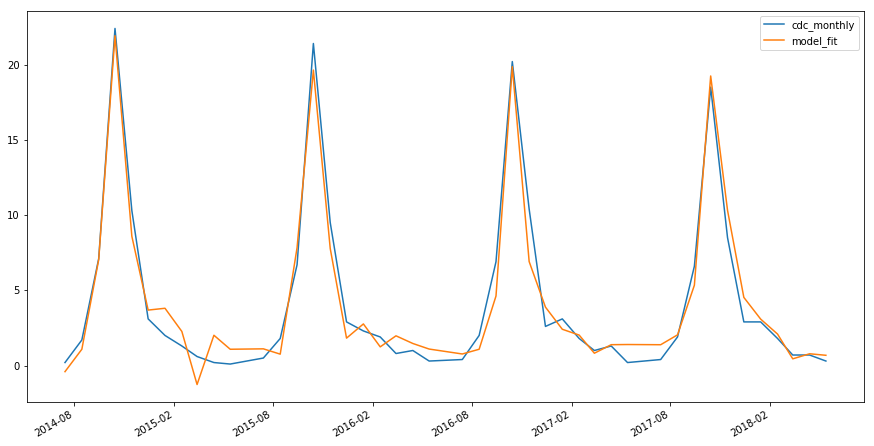


 

Florida:
R2 train:
0.822070026045703
The best fit coefficients: [[ 0.04126618  0.19899869 -0.03900539 -0.14185007]]
R2 test:
0.8781401141173796


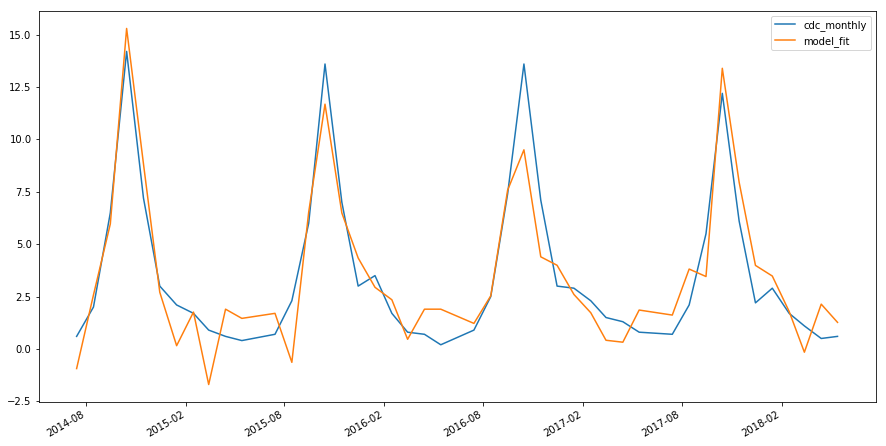


 

Georgia:
R2 train:
0.9533428239506944
The best fit coefficients: [[-0.08756846  0.3731252  -0.02394835 -0.14403979]]
R2 test:
0.8686374227313378


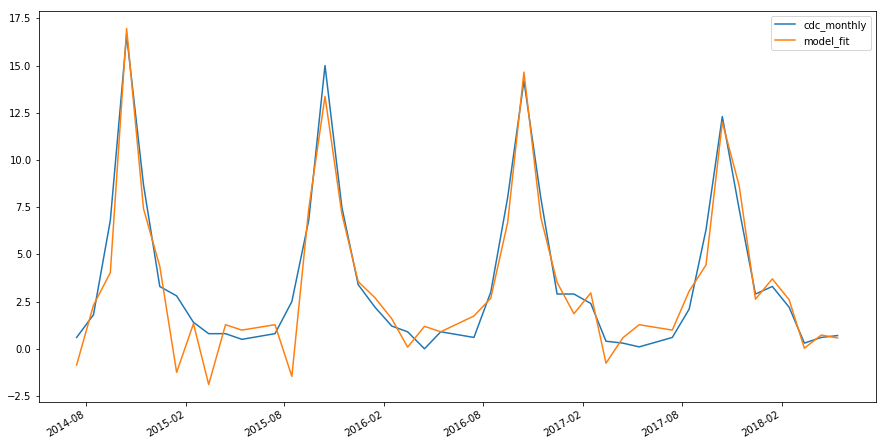


 

Illinois:
R2 train:
0.9466725769899043
The best fit coefficients: [[ 0.05501902  0.32407617 -0.04259146 -0.09890566]]
R2 test:
0.9187082870079284


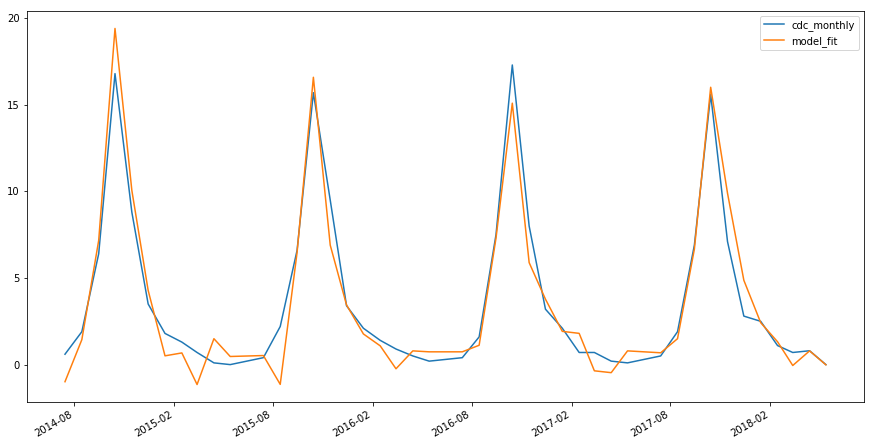


 

Indiana:
R2 train:
0.952161185007279
The best fit coefficients: [[ 0.01643099  0.23377659 -0.02702499 -0.09871054]]
R2 test:
0.8625980769622157


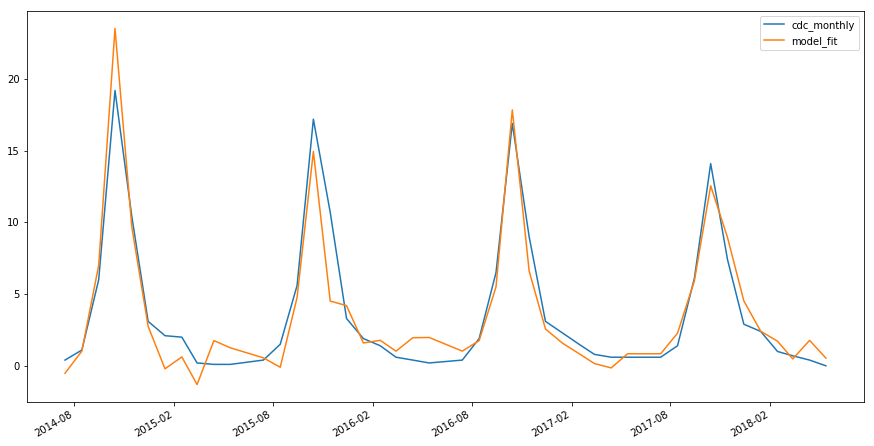


 

Louisiana:
R2 train:
0.8648560253462588
The best fit coefficients: [[ 0.05550089  0.16845866 -0.01698869 -0.0746297 ]]
R2 test:
0.86532280078809


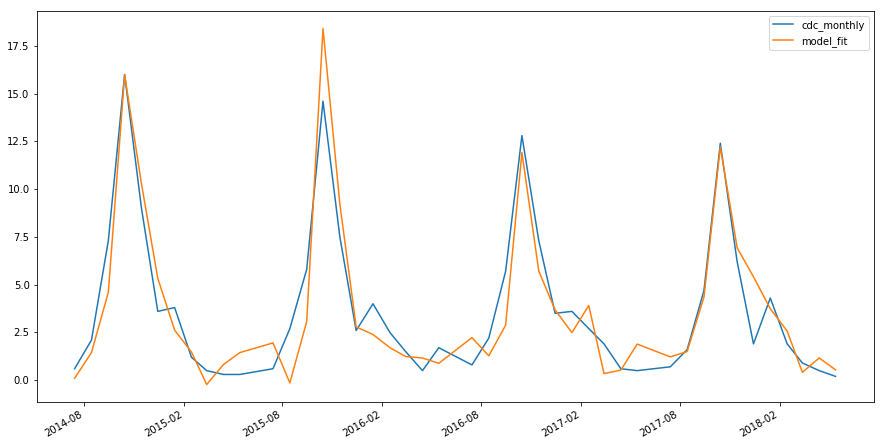


 

Massachusetts:
R2 train:
0.9219963032814164
The best fit coefficients: [[ 0.06672554  0.25848175 -0.08712484 -0.12008844]]
R2 test:
0.8687734436342113


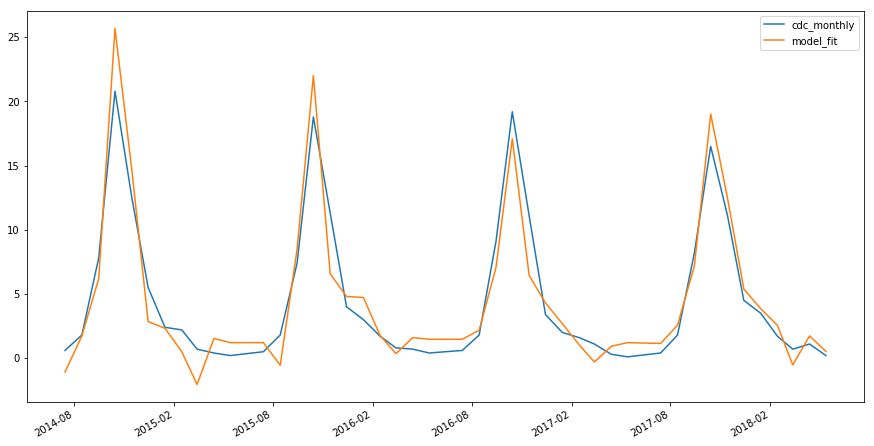


 

Missouri:
R2 train:
0.918962488068433
The best fit coefficients: [[ 0.12368685  0.22381065 -0.02315096 -0.09911856]]
R2 test:
0.9227188205171918


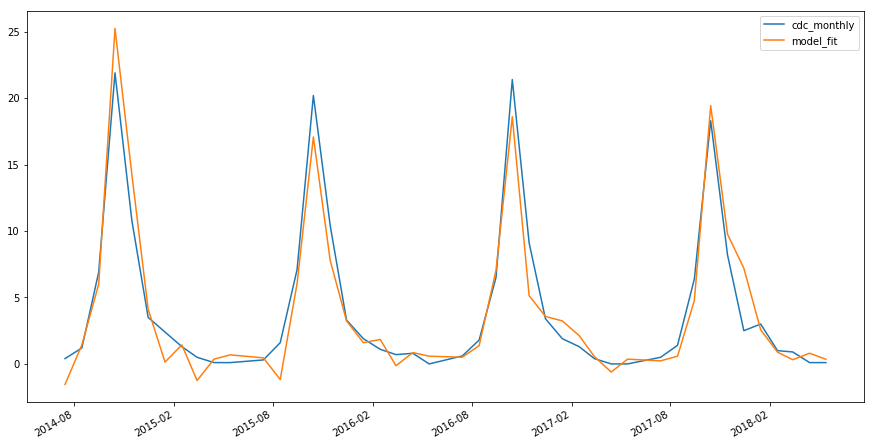


 

North Carolina:
R2 train:
0.9571735272158266
The best fit coefficients: [[ 0.03843329  0.30230748 -0.08450984 -0.11159939]]
R2 test:
0.9393989480310564


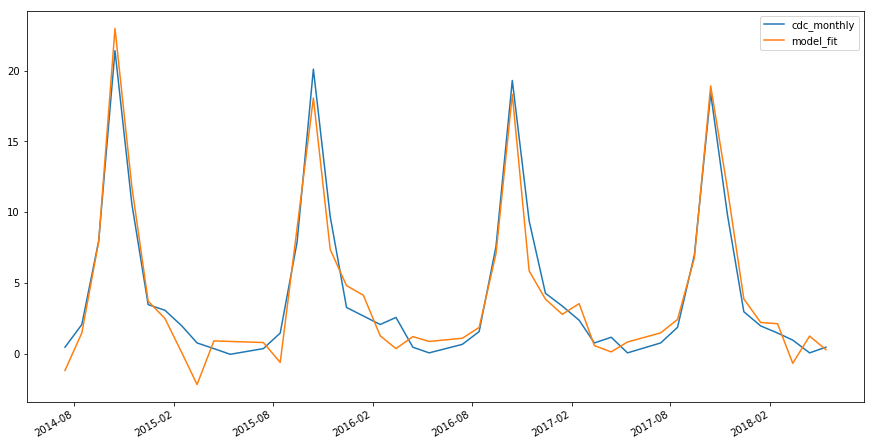


 

New Jersey:
R2 train:
0.8955148292712999
The best fit coefficients: [[ 0.05367951  0.23840224 -0.12454127 -0.12624402]]
R2 test:
0.9199036472973963


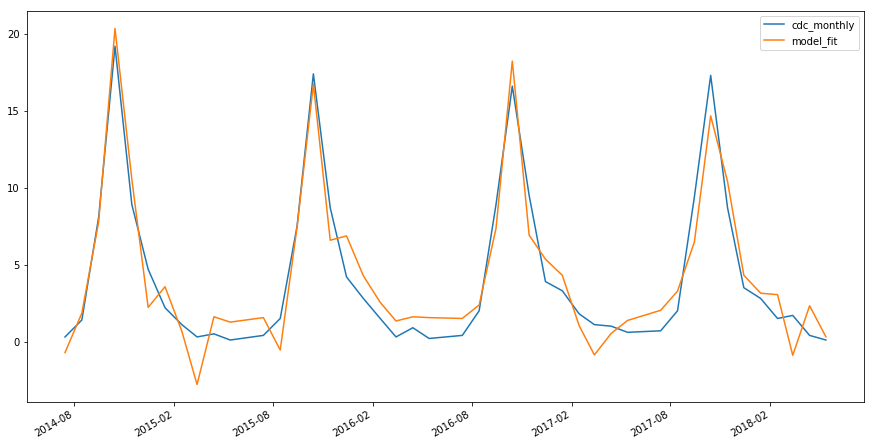


 

New York:
R2 train:
0.8990224771332368
The best fit coefficients: [[-0.05924742  0.3468146  -0.08555066 -0.1635366 ]]
R2 test:
0.8763780310230668


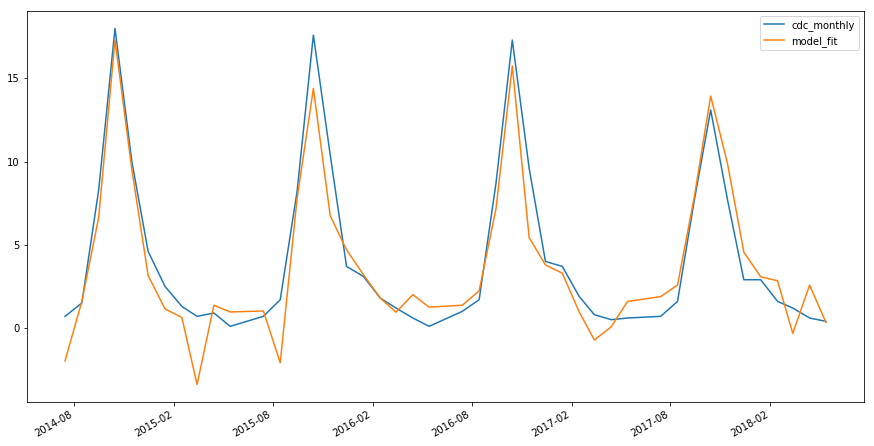


 

South Carolina:
R2 train:
0.8568357881958808
The best fit coefficients: [[ 0.08722194  0.22294572 -0.10217053 -0.12523558]]
R2 test:
0.8655919769799633


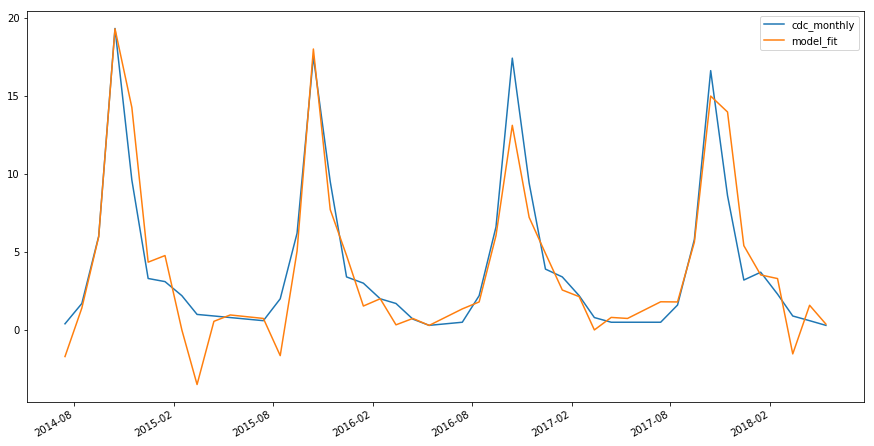


 

Tennessee:
R2 train:
0.9055525109383055
The best fit coefficients: [[ 0.06763212  0.22133894 -0.06945703 -0.05946524]]
R2 test:
0.823121801001991


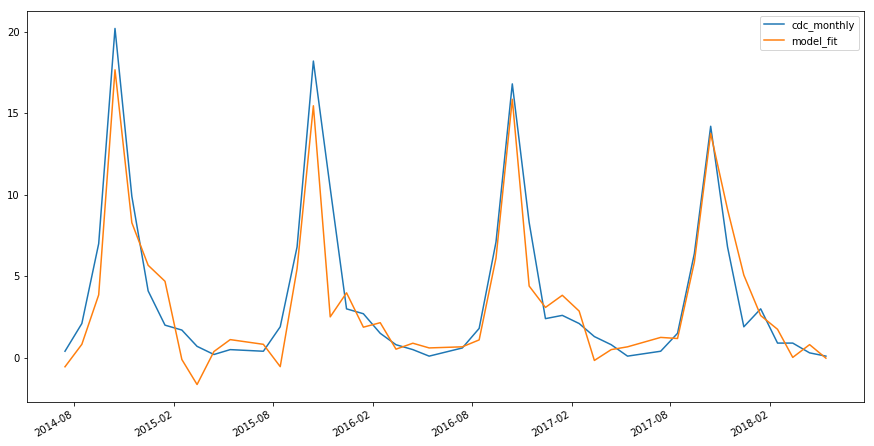


 

Texas:
R2 train:
0.9237683263602177
The best fit coefficients: [[-0.0021858   0.30692844 -0.03554428 -0.10147793]]
R2 test:
0.8854367546846085


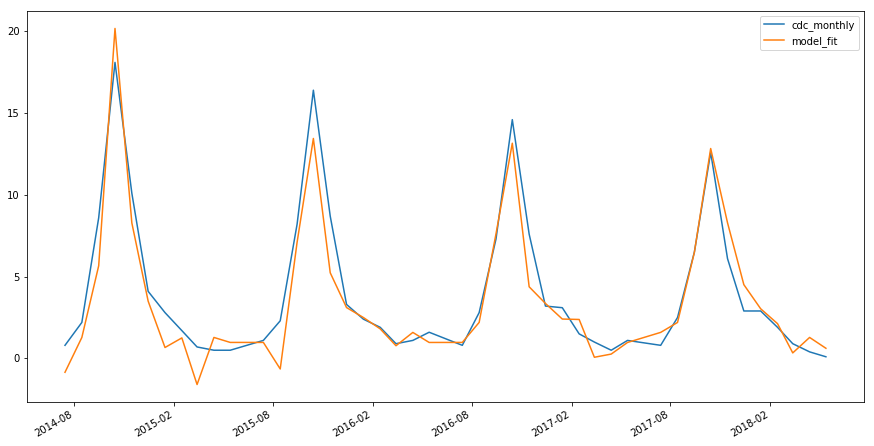


 

Virginia:
R2 train:
0.9455742405536199
The best fit coefficients: [[ 0.09399076  0.29371145 -0.06499502 -0.14260748]]
R2 test:
0.7851514544345025


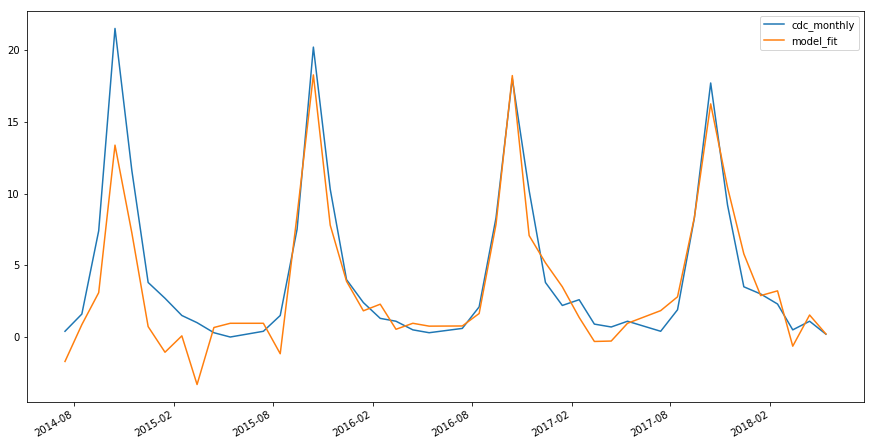


 

Washington:
R2 train:
0.9092190916205617
The best fit coefficients: [[ 0.04447117  0.25598655 -0.0292868  -0.11858765]]
R2 test:
0.9112349539587381


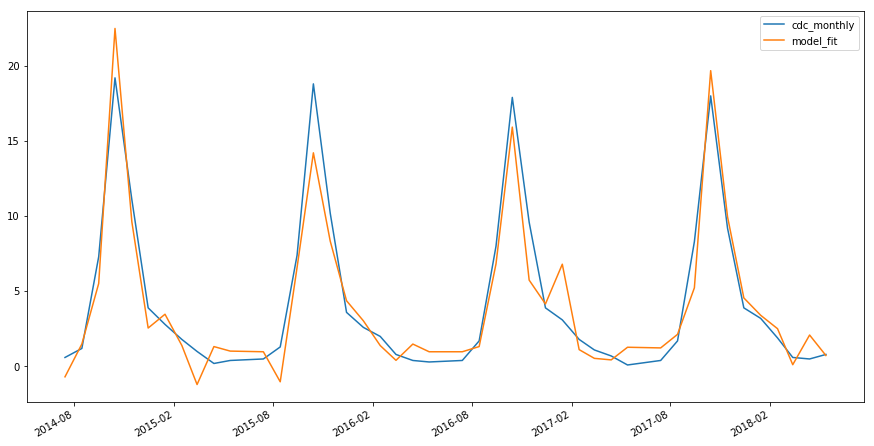

In [17]:
%pylab inline
figsize(15,8)
import time

r2_bystate = pd.DataFrame()

valid_states = ['Alabama', 'Arkansas', 'Arizona', 'California', 'Colorado', 'Florida', 'Georgia', 'Illinois', 'Indiana', 'Louisiana', 'Massachusetts', 'Missouri', 'North Carolina', 
'New Jersey', 'New York', 'Rhose Island', 'South Carolina', 'Tennessee', 'Texas', 'Virginia', 'Washington']

for abbr, name in states.items():

    if (name not in valid_states):
        continue
    
    state_df = get_state_target_df(cdc, gtrends_shot, gtrends_news, abbr, name)
    state_df["cdc_monthly"] = cdc_increment(state_df.index, state_df.cdc)
    
    state_df = state_df[state_df.index > pd.Timestamp('2014-05-20')]
    
    print(name + ":")

    print("R2 train:")
    reg = train_linear_model(state_df)
    
    print("The best fit coefficients: " + str(reg.coef_))

    print("R2 test:")
    r2_bystate[name], model_fit = test_linear_model(state_df, reg)

    state_df['model_fit'] = model_fit
    
    fig = state_df[['cdc_monthly', 'model_fit']].plot()
    
    plt.show()
        
    print("\n \n")


Now we can see what the R2s look like, and plot the results:

In [18]:
r2 = r2_bystate.transpose()
r2.columns = ['R2_monthly', '2014_monthly', '2015_monthly', '2014', '2015']

In [19]:
r2

,R2_monthly,2014_monthly,2015_monthly,2014,2015
Alabama,0.868670,0.838189,0.905025,0.928524,0.983294
Arkansas,0.915963,0.916651,0.914976,0.969670,0.964886
Arizona,0.946722,0.950811,0.942833,0.921198,0.980198
California,0.881211,0.842399,0.924162,0.871905,0.952103
Colorado,0.966035,0.964771,0.967496,0.991751,0.981708
Florida,0.878140,0.886131,0.869202,0.987272,0.972098
Georgia,0.868637,0.849598,0.891908,0.839886,0.933456
Illinois,0.918708,0.923932,0.912903,0.986405,0.907939
Indiana,0.862598,0.900694,0.816724,0.985096,0.796868
Louisiana,0.865323,0.933161,0.767947,0.981343,0.988704


In [20]:
r2_plotting = r2[['2014', '2015']]
r2_plotting.columns = ['2014-2015', '2015-2016']


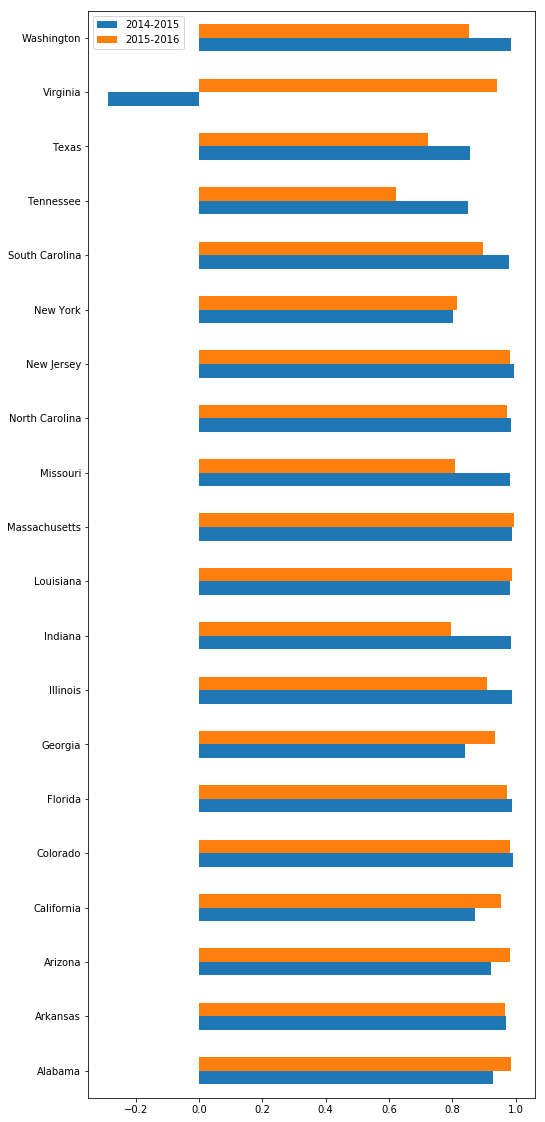

In [21]:
figsize(8,20)
r2_plotting.plot.barh()

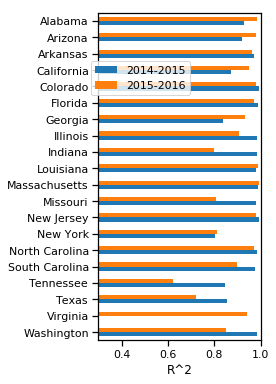

In [22]:
import seaborn as sns
sns.set_context('notebook')
fig, ax = plt.subplots(figsize=(4,5.5))

r2_plotting.sort_index(ascending=False).plot.barh(ax=ax).legend(bbox_to_anchor=(0.6, 0.8));
ax.set_xlabel('R^2');
ax.set_xlim(0.3, 1);
ax.set_ylabel('');

fig.tight_layout()

fig.savefig('model_predictions_cumulative.jpg', dpi=150)


In [23]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h



In [24]:

print(mean_confidence_interval(r2['2014']))
print(mean_confidence_interval(r2['2015']))

print(mean_confidence_interval(r2['2014_monthly']))
print(mean_confidence_interval(r2['2015_monthly']))

(0.879814129463232, 0.13166028496038065)
(0.9032567367671124, 0.04815317686202629)
(0.8877578427189222, 0.03217739773618221)
(0.888386397665607, 0.02683386209610321)


Populating the interactive namespace from numpy and matplotlib
Alabama:
0.9297998161872024
[[ 0.19352513  0.05987046 -0.02412571 -0.13736955]]
0.8686697750449845


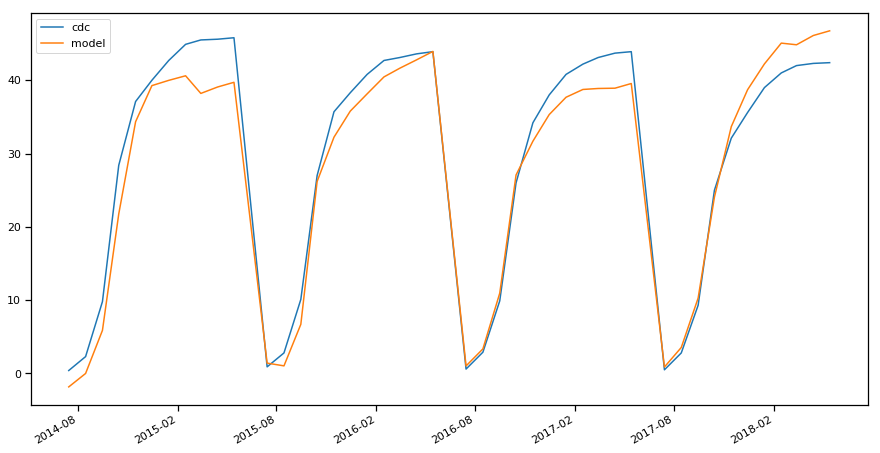


 

Arkansas:
0.8460528941700478
[[ 0.06435658  0.35873163 -0.10951578 -0.04241015]]
0.9159627667150794


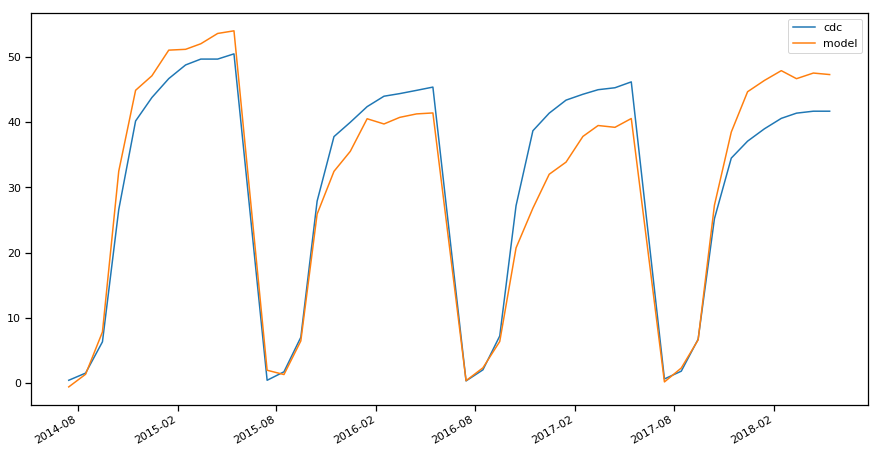


 

Arizona:
0.8601822767845739
[[ 0.0830393   0.14992616 -0.00784165 -0.0911558 ]]
0.9467220224746699


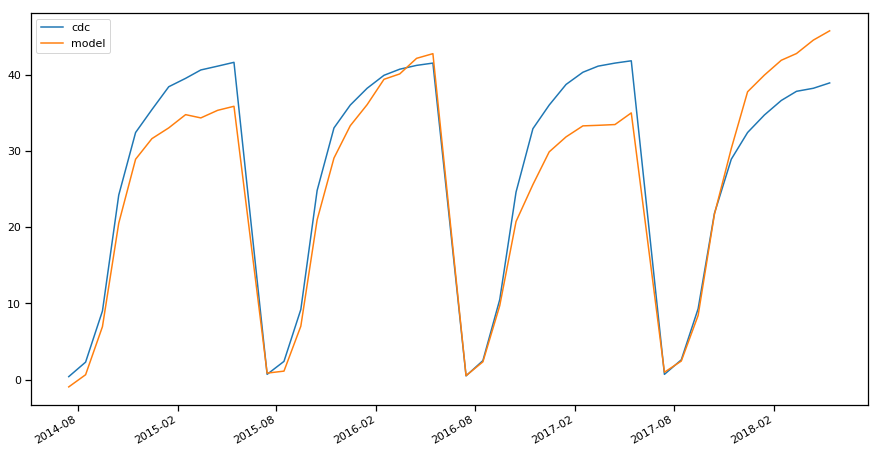


 

California:
0.9094580786709074
[[-0.00955461  0.22391664  0.00768417 -0.13341313]]
0.881210636358991


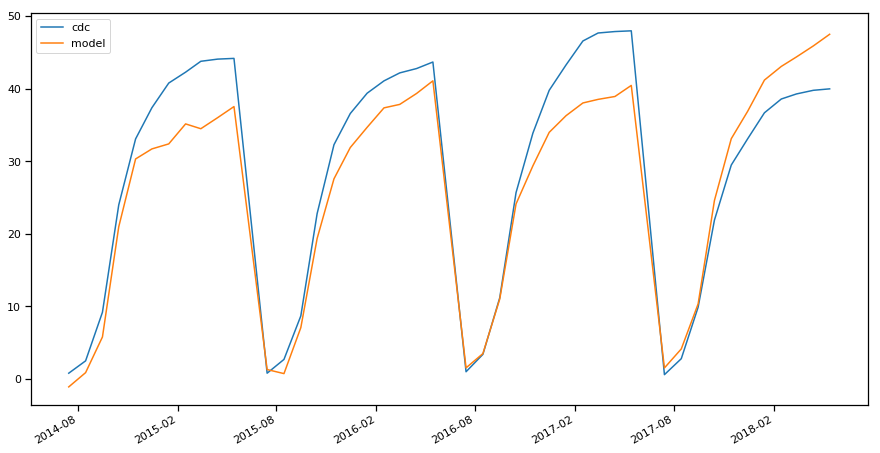


 

Colorado:
0.9523788797975996
[[ 0.01373384  0.31449858 -0.04146393 -0.06679419]]
0.9660345254446137


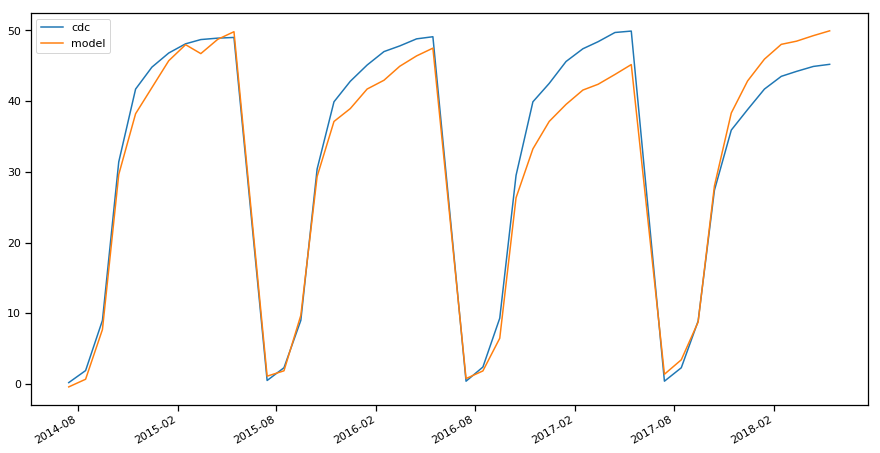


 

Florida:
0.822070026045703
[[ 0.04126618  0.19899869 -0.03900539 -0.14185007]]
0.8781401141173796


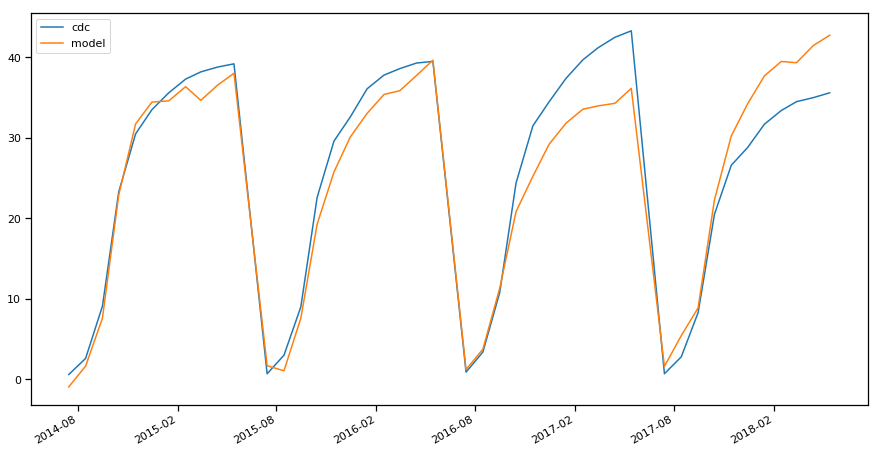


 

Georgia:
0.9533428239506944
[[-0.08756846  0.3731252  -0.02394835 -0.14403979]]
0.8686374227313378


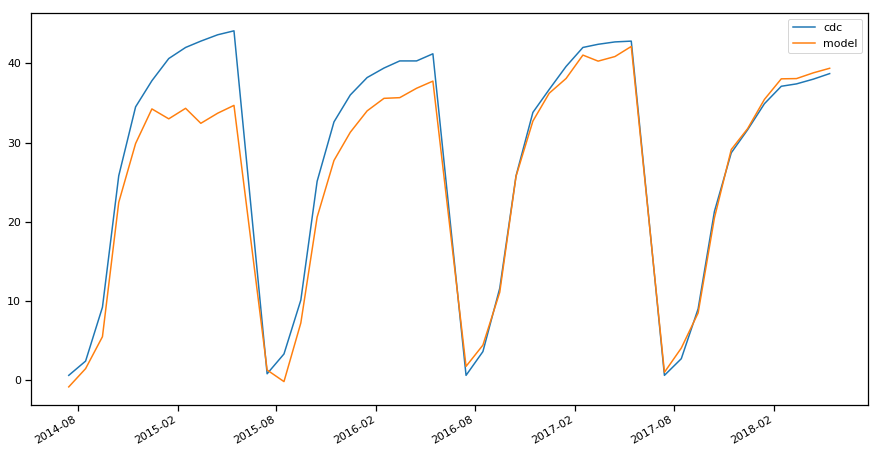


 

Illinois:
0.9466725769899043
[[ 0.05501902  0.32407617 -0.04259146 -0.09890566]]
0.9187082870079284


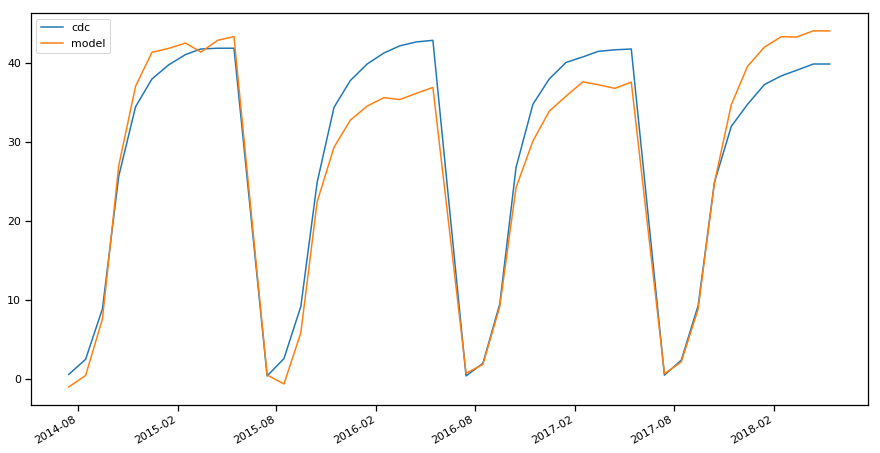


 

Indiana:
0.952161185007279
[[ 0.01643099  0.23377659 -0.02702499 -0.09871054]]
0.8625980769622157


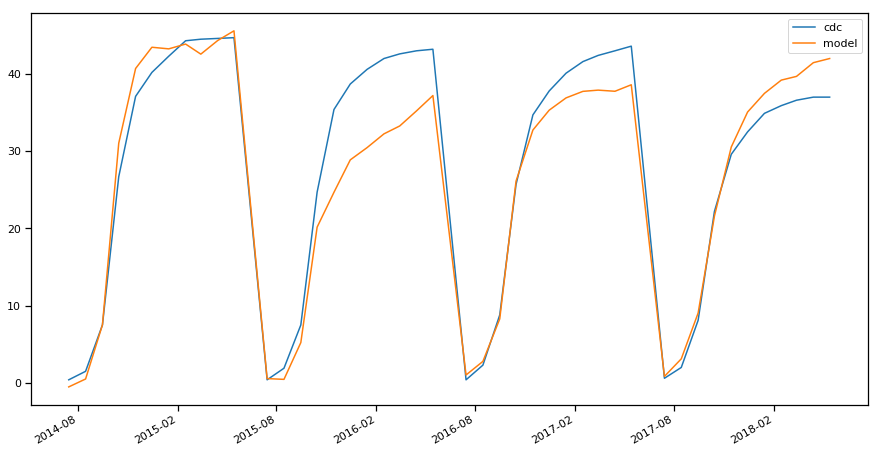


 

Louisiana:
0.8648560253462588
[[ 0.05550089  0.16845866 -0.01698869 -0.0746297 ]]
0.86532280078809


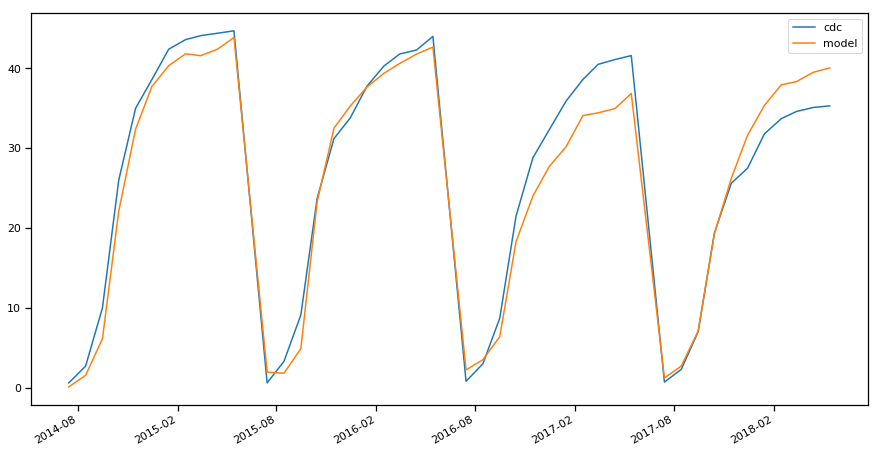


 

Massachusetts:
0.9219963032814164
[[ 0.06672554  0.25848175 -0.08712484 -0.12008844]]
0.8687734436342113


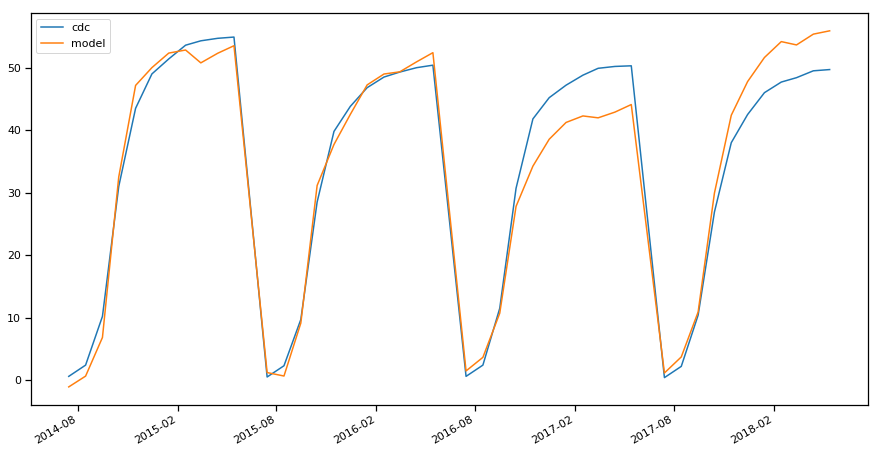


 

Missouri:
0.918962488068433
[[ 0.12368685  0.22381065 -0.02315096 -0.09911856]]
0.9227188205171918


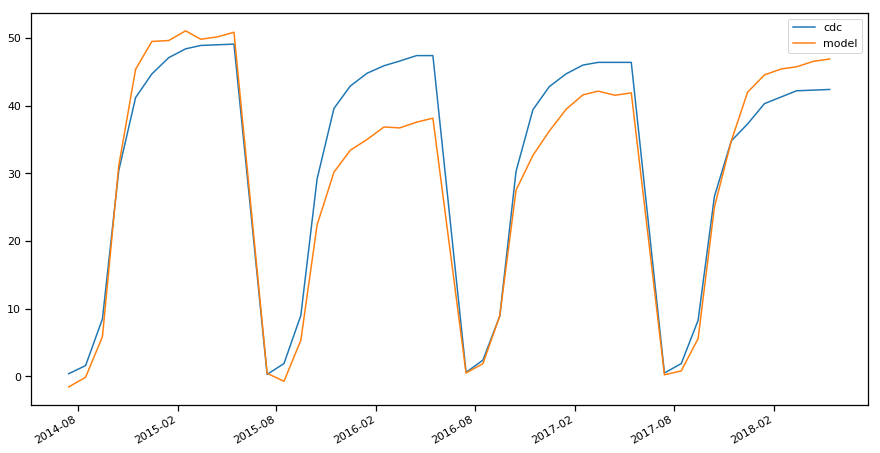


 

North Carolina:
0.9571735272158266
[[ 0.03843329  0.30230748 -0.08450984 -0.11159939]]
0.9393989480310564


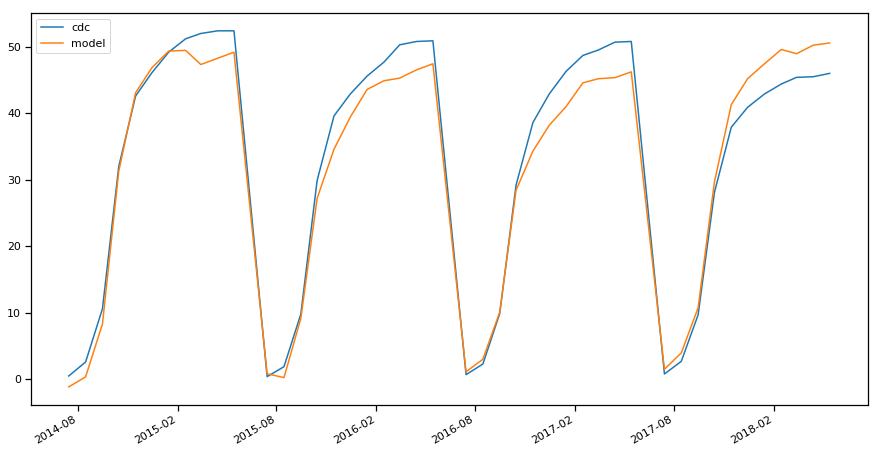


 

New Jersey:
0.8955148292712999
[[ 0.05367951  0.23840224 -0.12454127 -0.12624402]]
0.9199036472973963


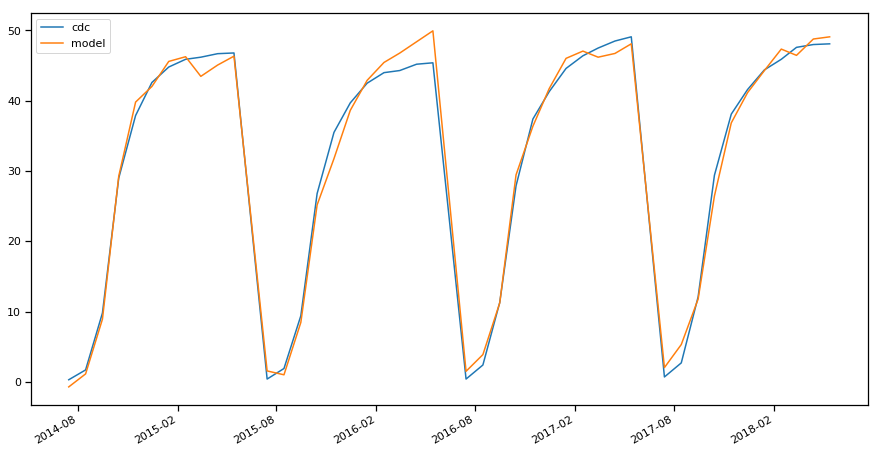


 

New York:
0.8990224771332368
[[-0.05924742  0.3468146  -0.08555066 -0.1635366 ]]
0.8763780310230668


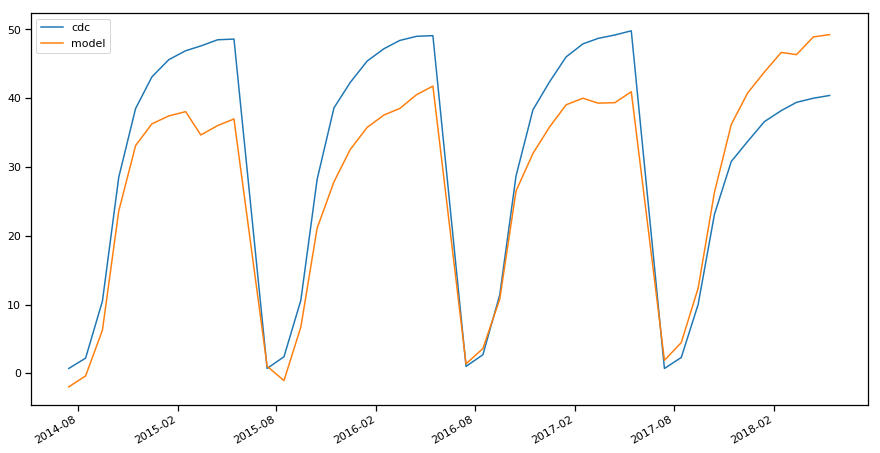


 

South Carolina:
0.8568357881958808
[[ 0.08722194  0.22294572 -0.10217053 -0.12523558]]
0.8655919769799633


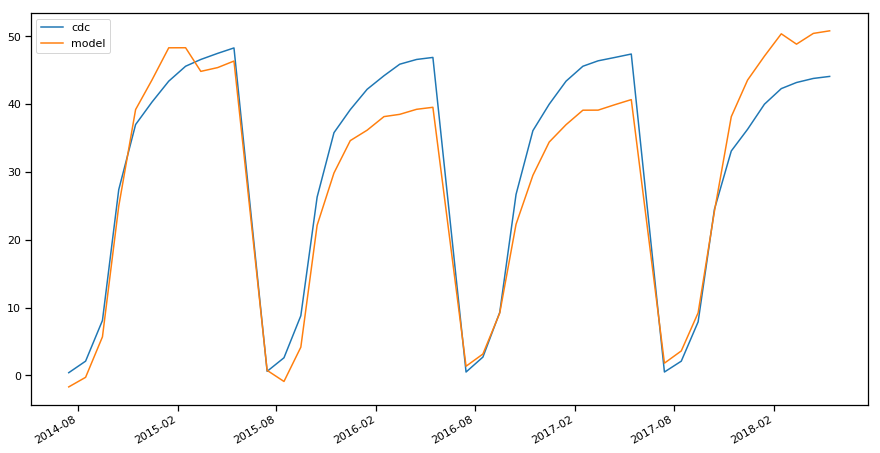


 

Tennessee:
0.9055525109383055
[[ 0.06763212  0.22133894 -0.06945703 -0.05946524]]
0.823121801001991


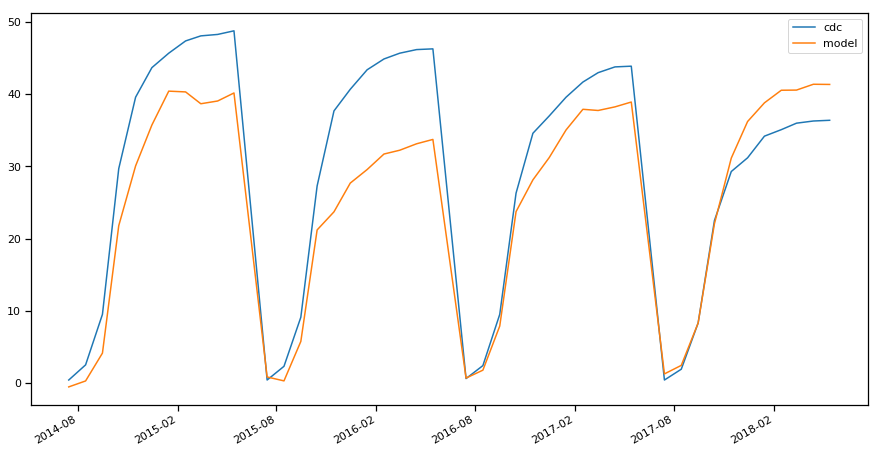


 

Texas:
0.9237683263602177
[[-0.0021858   0.30692844 -0.03554428 -0.10147793]]
0.8854367546846085


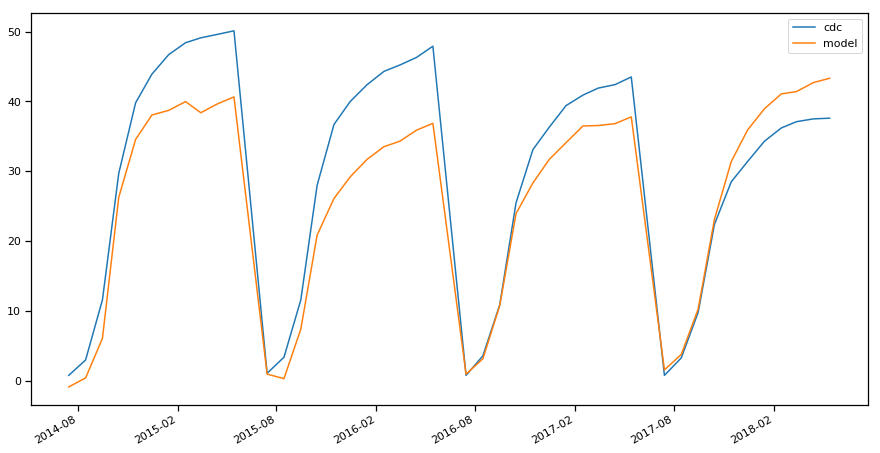


 

Virginia:
0.9455742405536199
[[ 0.09399076  0.29371145 -0.06499502 -0.14260748]]
0.7851514544345025


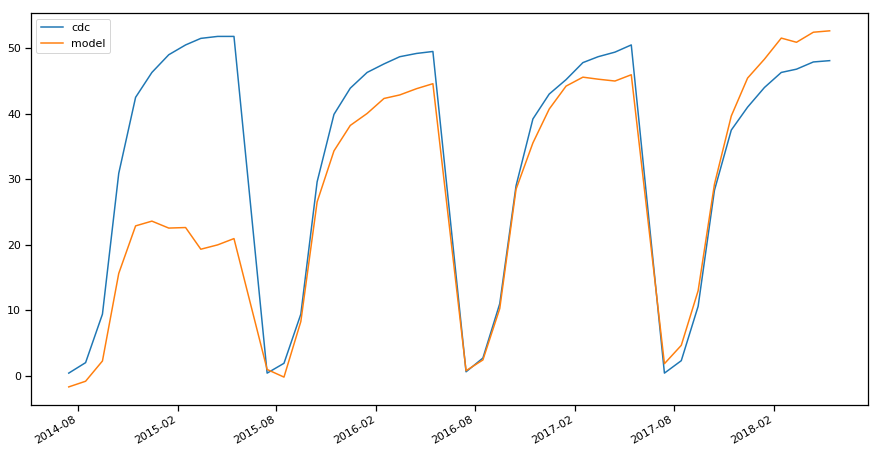


 

Washington:
0.9092190916205617
[[ 0.04447117  0.25598655 -0.0292868  -0.11858765]]
0.9112349539587381


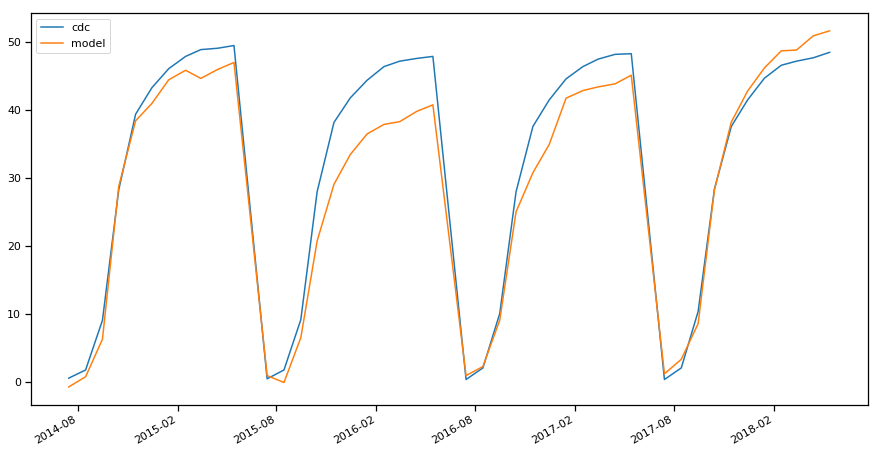

In [25]:
%pylab inline
figsize(15,8)
import time

r2_bystate = pd.DataFrame()

for abbr, name in states.items():

    if (name not in valid_states):
        continue
    
    state_df = get_state_target_df(cdc, gtrends_shot, gtrends_news, abbr, name)
    state_df["cdc_monthly"] = cdc_increment(state_df.index, state_df.cdc)

    state_df = state_df[state_df.index > pd.Timestamp('2014-05-20')]
    
    print(name + ":")

    reg = train_linear_model(state_df)
    print(reg.coef_)

    r2_bystate[name], model_fit = test_linear_model(state_df, reg)

    state_df['model_fit'] = model_fit

    state_df['model'] = cdc_deincrement(state_df.index, state_df.model_fit)
    
    fig = state_df[['cdc', 'model']].plot()
    
    plt.show()
        
    print("\n \n")
